This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import os, glob
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import netCDF4
import math
import os
import gc
import matplotlib.pyplot as plt
from hydrogeol_utils.db_utils import makeCon, closeCon

In [2]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'C:\Users\PCUser\Desktop\EK_data\AEM'


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
nbc_cond = netCDF4.Dataset(cond_path)



In [3]:
nbc_cond['layer_top_depth']

<class 'netCDF4._netCDF4.Variable'>
float32 layer_top_depth(point, layer)
    long_name: Depth to the top of the layer
    units: m
    aseg_gdf_format: 30E9.3
unlimited dimensions: 
current shape = (641851, 30)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
# Open the LCI inversion

cond_path = os.path.join(ncdir,'OrdK_LCI_MGA52.nc')
lci_cond = netCDF4.Dataset(cond_path)


In [5]:
# Create an instance of plots for gridding the data

nbc_plots = plot_utils.ConductivitySectionPlot(nbc_cond)
lci_plots = plot_utils.ConductivitySectionPlot(lci_cond)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation',
                               'easting', 'northing']

nbc_plots.conductivity_variables = cond_vars
lci_plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 3.

In [6]:
# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

SPATIALITE_PATH = r'C:\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)


connection = makeCon(DB_PATH)

# Open the borehole data as a pandas dataframe

df_header =pd.read_sql('select * from borehole', connection)


enos = df_header['borehole_id'].values

# Extract the induction gamma
df_induction = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity',
                                                         'borehole_id'], connection, enos,
                                                       verbose = True)
df_induction.dropna(how='any', inplace=True)

Connected to C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite. Temporary working copy created.
select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (621622,621623,621624,621625,626981,626984,626986,626987,626988,626989,626990,626991,626992,627061,627062,627063,627064,628981,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635747,635748,635749,635750,635920,635921,635922,635923,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636187,636188,636189,636190,636191,636192,636193,636194,636195,636196,636197,636198,636200,636201,636203,636204,636205);


In [7]:
# Extract the AEM conductivity using nearest neighbour

# Get the utm coordinates for the AEM survey
cond_point_utils = NetCDFPointUtils(nbc_cond)

utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          aem_coords,
                                                          points_required = 1,# return 10 closest points
                                                          max_distance = 200.)

# Remove the bores that are >250 m from AEM lines

nanmask = np.isnan(distances)

# Now find the lines with induction logs on them

lines = np.unique(nbc_cond['line'][nbc_cond['line_index'][indices[~nanmask]]])

In [8]:
# Lines supplied by Mr Gibbo

#lines = [301701, 302101, 303101, 303901, 304601, 305301,
#         306002, 308202, 309201, 310101, 311501, 312301,
#         314401, 317201, 318201, 319501, 320002]

#lines = [ 321301, 322201, 322701, 323801, 324701]

lines = [300701]

In [9]:
# Grid the NBC and save it in memory
hdf5_nbc_dir = r"C:\temp\hdf5_Keep_NBC"

if not os.path.exists(hdf5_nbc_dir):
    os.mkdir(hdf5_nbc_dir)
    
nbc_lci_dir = r"C:\temp\hdf5_lci_NBC"

if not os.path.exists(nbc_lci_dir):
    os.mkdir(nbc_lci_dir)



NBC_gridded_variables = nbc_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = True, return_dict = True,
                                                 hdf5_dir = hdf5_nbc_dir)

LCI_gridded_variables = lci_plots.grid_variables(xres = xres, yres =yres, lines=lines, smoothed=False,
                                                 resampling_method = 'linear', save_hdf5 = True, return_dict = True,
                                                 hdf5_dir = nbc_lci_dir)


In [10]:
outdir = r"C:\Users\PCUser\Desktop\EK_data\AEM\comparison_sections_Aug2019_induction"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [28]:
eno = 621622

mask = df_header['borehole_id'] == eno

x,y = df_header[mask].Easting[0], df_header[mask].Northing[0]

x

478993.383

In [ ]:
# We apply a Butterworth filter



In [11]:
# The induction data is far too dense for plotting so we resample

#Define the depth interval
interval = 1.

# Create an empty dataframe
df_induction_resampled = pd.DataFrame(columns=['borehole_id', 'X', 'Y',
                                               'Depth', 'Apparent_conductivity'])

# ITerate through the bores
for item in df_induction['borehole_id'].unique():
    # Get a mask for the bore we are operating on
    mask= df_induction['borehole_id'] == item

    # define the new depth intervals
    new_depths = np.arange(math.ceil(df_induction[mask]['Depth'].min()),
                           math.floor(df_induction[mask]['Depth'].max()),
                           interval)
    
    # Create an array of resampled depths and values
    df_resampled = spatial_functions.interpolate_depth_data(df_induction[mask],
                                                            'Apparent_conductivity', 
                                                            'Depth', new_depths = new_depths)
    
    # Now we fill in the other columns with the borehole spatial information and eno
    df_resampled['borehole_id'] = item
    df_resampled['X'] = df_header[df_header['borehole_id'] == item]['Easting'].iloc[0]
    df_resampled['Y'] = df_header[df_header['borehole_id'] == item]['Northing'].iloc[0]
    
    # Append
    df_induction_resampled = df_induction_resampled.append(df_resampled)


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [13]:
line = lines[0]

Figure saved


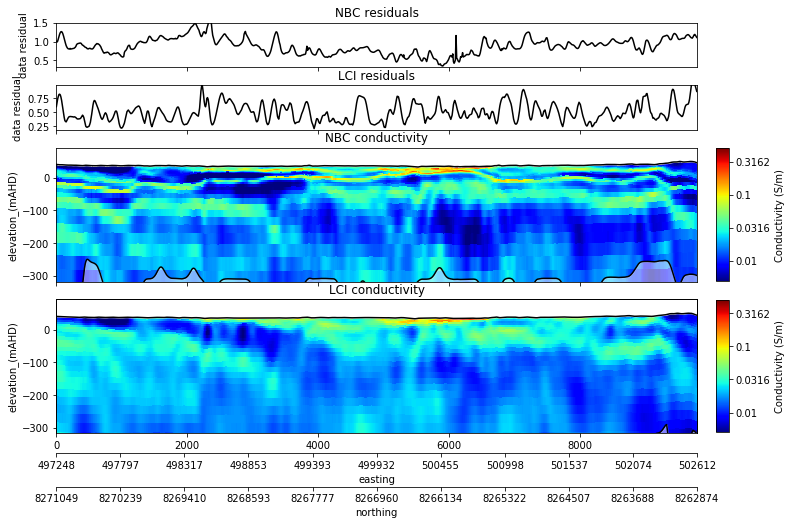

In [21]:
# Panel plotting different CGI inversions

vex = 5.

max_depth = 350.

vmin, vmax = 0.005,0.5

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'NBC residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_2': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'LCI residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'NBC conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 3},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'LCI conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 3}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.,
                    'panel_vgap': 0.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})

res1 = plot_utils.plot_single_line(ax_array[0], NBC_gridded_variables[line],
                                   'data_residual', panel_kwargs[0])

ax_array[0].set_title(panel_kwargs[0]['title'])

res2 = plot_utils.plot_single_line(ax_array[1], LCI_gridded_variables[line],
                                   'data_residual', panel_kwargs[1])

ax_array[1].set_title(panel_kwargs[1]['title'])

im1 = plot_utils.plot_grid(ax_array[2], NBC_gridded_variables[line], 'conductivity',
                   panel_kwargs[2])

ax_array[2].set_title(panel_kwargs[2]['title'])


im2 = plot_utils.plot_grid(ax_array[3], LCI_gridded_variables[line], 'conductivity',
                    panel_kwargs[3])

ax_array[3].set_title(panel_kwargs[3]['title'])

# Find the minimum grid distance:
if LCI_gridded_variables[line]['grid_distances'][-1] > NBC_gridded_variables[line]['grid_distances'][-1]:
    
    xmin = NBC_gridded_variables[line]['grid_distances'][-1]
    east = NBC_gridded_variables[line]['easting']
    nor = NBC_gridded_variables[line]['northing']

else:
    xmin = LCI_gridded_variables[line]['grid_distances'][-1]
    east = LCI_gridded_variables[line]['easting']
    nor = LCI_gridded_variables[line]['northing'] 
    


ax_array[3].set_xlim(0,xmin)

#ax_array[3].set_xlim(20000,25000)

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)

savefig = False

# Add the induction
for bore in enos:
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for i, ax in enumerate(ax_array[2:]):
        
        cstretch = [panel_kwargs[i+2]['vmin'], panel_kwargs[i+2]['vmax']]
        
        log= plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask],
                                         NBC_gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=cstretch, log_stretch = True,
                                         stick_thickness=250.)
        if log is not None:
            savefig = True
            

# Add colorbars
plot_utils.add_colourbar(fig, ax_array[2], im1, x0, y0, width, height, panel_kwargs[2])

plot_utils.add_colourbar(fig, ax_array[3], im2, x0, y0, width, height, panel_kwargs[3])

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

plot_utils.add_axis_coords('northing', nor, ax_array[-1], ax_pos[3], offset=-0.4)

plot_utils.add_axis_coords('easting', east, ax_array[-1], ax_pos[3], offset=-0.15)

    
outfile = os.path.join(outdir, str(line) + "_LCI_NBC_comparison_plot_log.png")

savefig = True

if savefig:
    print('Figure saved')
    plt.savefig(outfile, dpi=300)

plt.show()

In [107]:
from scipy import signal



def plot_induction_AEM(eno, AEM_datasets, filter_log = False,
                      xlim = (0.0001,1)):
    """
    eno: borehole_id
    datasets: list of netcdf object AEm datasets
    """
    
   
    # Create a mask
    
    mask = df_header['borehole_id'] == eno

    xy = df_header[mask][['Easting','Northing']]
    
    # Get the conductivity profile for each dataset
    profiles = []
    
    for d in AEM_datasets:
        cond_point_utils = NetCDFPointUtils(d)

        utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)
        
        dist, ind = spatial_functions.nearest_neighbours(xy.values,
                                                       aem_coords,
                                                       points_required = 1,
                                                       max_distance = 250.)
        

        if np.isnan(dist).all():
            print('No AEM with 250 m')
            return None
            
        
        # Get the conductivity profile
        profiles.append(AEM_utils.extract_conductivity_profile(d,dist, ind,
                                                               as_dataframe = True,
                                                               mask_below_doi=True))


    fig, ax_array = plt.subplots(1,len(profiles) + 1, sharey = True,
                                 sharex=True, figsize = (8,6))
        
    # Extract the induction data
    
    df_ind = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity'],
                                                         connection, [eno],
                                                          verbose = False)
    if filter_log:
        df_ind = butterw()
        
    
    depth, induction_profile = df_ind['Depth'].values, df_ind['Apparent_conductivity'].values 
        
    ax_array[-1] = plot_utils.plot_downhole_log(ax_array[-1], df_ind['Apparent_conductivity'].values,
                                                df_ind['Depth'].values, log_plot=True)
    ax_array[-1].set_title("Borehole induction data")

    ax_array[-1].set_xlabel("borehole induction conductivity (S/m)")
    
    # Iterate through the datasets and plot them
    for i, df_conductivity_profile in enumerate(profiles):
        depth_mask = df_conductivity_profile['Depth_to'] < df_ind['Depth'].max() + 20.
      
        ax_array[i] = plot_utils.plot_1D_layered_model(ax_array[i],
                                                       df_conductivity_profile.loc[depth_mask,'conductivity'].values,
                                                       df_conductivity_profile.loc[depth_mask,'Depth_from'].values, 
                                                       doi=None, log_plot=True)
        
        
        ax_array[i].set_ylabel("Depth")
        ax_array[i].set_xlabel("AEM bulk Conductivity (S/m)")
        
    
    # Reverse the y axis for deth logical scale
    ax_array[0].set_ylim(ax_array[0].get_ylim()[::-1])
    ax_array[-1].set_xlim(xlim)
    return fig, ax_array



(<Figure size 576x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000256B26111C8>,
       dtype=object))

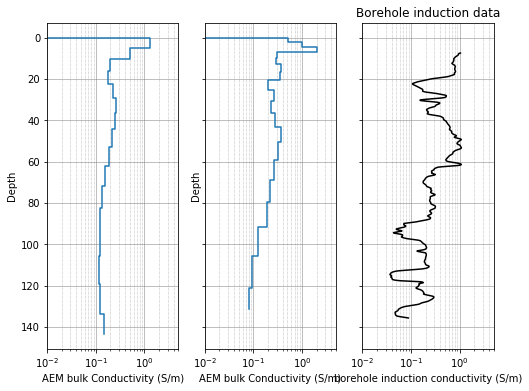

In [116]:
plot_induction_AEM(635744, [lci_cond, nbc_cond], filter_log = False,
                  xlim = (0.01,5))

In [112]:
df_induction_test = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity',
                                                         'borehole_id'], connection, [635922],
                                                       verbose = True)
df_induction_test.dropna(how = 'any',inplace=True)
depths = df_induction_test.Depth.values
cond = df_induction_test.Apparent_conductivity.values


select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (635922);


In [129]:
len(cond)

5785

In [229]:
def butterw(values, delta, bwfreq, bwOrder = 4):
    """
    values: 1d numpy array of values to be filtered
    delta: sampling frequency
    bwfrequ: filter cutoff
    """

    npad = int(round(2.0/(bwfreq*delta)))

    n = values.shape[0] + 2 * npad
    print(npad)

    xpad = np.zeros(shape = (n), dtype = values.dtype)
    
    # pad the start adn end of the arrays
    xpad[0:npad] = np.repeat(values[0],npad)
    xpad[-npad:] = np.repeat(values[-1],npad)
    
    # Assign the unpadded part of the array to the values
    xpad[npad:-npad] = values
    # If an even number
    if n%2 == 0:
        f = np.arange(-(n)/2,(n/2))/(delta*n)
    
    # If an odd number
    else:

        f = np.arange(-(n-1)/2,(n-1)/2 + 1)/(delta*n)

    f = np.fft.fftshift(f)

    BWfilt_f = 1./np.sqrt(1.+ (f/bwfreq)**(2*bwOrder) )

    X_BW_f = np.fft.fft(xpad)*BWfilt_f

    outFilt =  np.fft.ifft(X_BW_f).real
    
    return outFilt[npad:-npad]



In [239]:
cond_filtered = butterw(cond, 0.05, 2, 2)

20


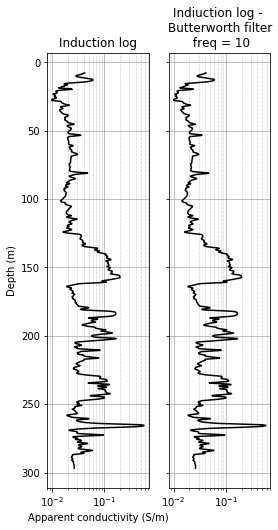

In [248]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (4,8))

plot_utils.plot_downhole_log(ax1, cond, depths, log_plot=True)

plot_utils.plot_downhole_log(ax2, cond_filtered, depths, log_plot=True)

ax1.set_title('Induction log')
ax2.set_title('Indiuction log - \nButterworth filter\n freq = 10')

ax1.set_xlabel('Apparent conductivity (S/m)')
ax1.set_ylabel('Depth (m)')

ax1.set_ylim(ax1.get_ylim()[::-1])
#ax1.set_ylim(50,100)
plt.savefig(r"C:\temp\filtered_comparison.png", dpi = 300)
plt.show()


C:\Users\PCUser\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


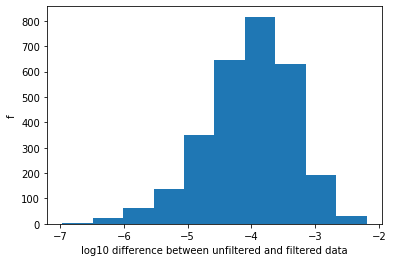

In [249]:
plt.hist(np.log10(cond_filtered - cond))
plt.xlabel('log10 difference between unfiltered and filtered data')
plt.ylabel('f')
plt.savefig(r"C:\temp\filtered_comparison_histogram.png", dpi = 300)
plt.show()

In [246]:
10/0.05

200.0

In [250]:
from scipy import signal

fc = 10  # Cut-off frequency of the filter
w = fc / (200 / 2) # Normalize the frequency
b, a = signal.butter(4, w, btype = 'lowpass')
w, h = signal.filtfilt(b, a, cond)





ValueError: too many values to unpack (expected 2)

In [114]:
df_header[df_header['Alternative_name'] == 'KR50b']

,borehole_id,Borehole_name,Alternative_name,Easting,Northing,Ground_elevation_mAHD,Induction_acquired,Gamma_acquired,Javelin_acquired,Hylogger_acquired_on_core,Hylogger_acquired_on_chips,Lithology_available,EC_pH_acquired,SWL_available,Construction_available,MagSus_available,AEM_conductivity_available,geometry,geom
33,635744,RN040780,KR50b,530338.125,8322496.983,5.094,1,1,1,1,1,0,1,0,1,1,1,POINT (530338.125 8322496.983),b'\x00\x01\xc0n\x00\x00\x00\x00\x00@D/ A\xd5x\...


In [110]:
df_header['Alternative_name'].values

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, 'Yow Bore', None, '17BP07I', '18BP07-D', 'KR08',
       'KR21a', 'KR22a', 'KR23', 'KR30', 'KR31', 'KR33', 'KR36', 'KR38',
       'KR40', 'KR45', 'KR46', 'KR48', 'KR49', 'KR50a', 'KR50b', 'KR51a',
       'KR51b', None, None, None, 'KR61', None, 'KR21b', '18BP13-D',
       '18BP01-D', None, None, None, None, None, None, None, None, None,
       None, '17BP02I', None, None, None, ' KC10,Ord16', 'Ord37',
       'WBS1155', 'Ord24', 'WBS5080', None, None, 'KC13', '10WP36',
       'KC14', 'Ord40', 'KC3PB', 'KC11'], dtype=object)